# Calibration
inspired by: http://jasss.soc.surrey.ac.uk/17/3/11.html

In [2]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
import powerlaw
from stockmarket import baselinemodel
from tqdm import tqdm
from pandas_datareader import data
from pylab import plot, show
from math import isclose
from stockmarket.stylizedfacts import *
import itertools
import quandl

# Import SPY data

### Prices

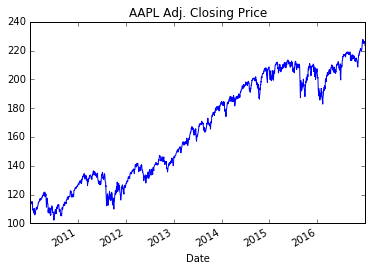

In [71]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

spy.plot(title='AAPL Adj. Closing Price')

### Returns

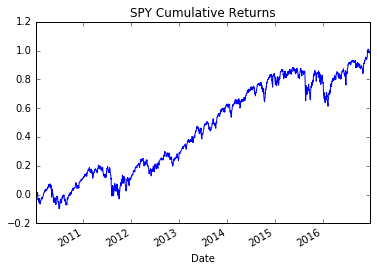

In [5]:
returns = spy.pct_change()
((1 + returns).cumprod() - 1).plot(title='SPY Cumulative Returns')

In [68]:
len(returns)

1761

### Price to earnings

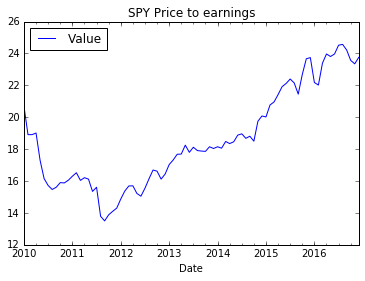

In [6]:
price_to_earning = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="8EKNms1cLLU-dBjk5Y4d").loc[start_date:end_date]
price_to_earning.plot(title='SPY Price to earnings')

## Calibrate agent_price_to_earnings_window with S&P 500 data

In [45]:
init_price_to_earnings_window = {}
price_to_earnings_descriptives = price_to_earning.describe()
init_price_to_earnings_window['lower_min'] = int(price_to_earnings_descriptives.loc['min']['Value'])
init_price_to_earnings_window['upper_min'] = int(price_to_earnings_descriptives.loc['25%']['Value'])

init_price_to_earnings_window['lower_max'] = int(price_to_earnings_descriptives.loc['75%']['Value'])
init_price_to_earnings_window['upper_max'] = int(price_to_earnings_descriptives.loc['max']['Value'])

init_price_to_earnings_window

{'lower_max': 21, 'lower_min': 13, 'upper_max': 24, 'upper_min': 16}

# 1 Calibrate zero intelligence benchmark to S&P 500 data

First we determine the value of money, initial profit and the discount rate by minimising the distance to the price to average price to earnings ratio observed in the S&P 500. 

| Parameter | Values |
| -------------| ------------|
| initial_total_money       | 13000 - 23000       |
| initial_profit       | 1000 - 10000    |
| discount_rate       | 0.01 - 0.25       |


$pricetoearningscriteria(x)=\left\{\begin{array}{cl}(\frac{av - x}{av})^2 & \quad \textrm{if} \quad\  lowerx < x < upperx,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

In [8]:
# Full factorial design for: 
initial_total_money = [x for x in range(26000, 33000, 2000)]
initial_profit = [x for x in range(1000, 10000, 2000)]
discount_rate = [x / 100 for x in range(1, 25, 2)]
factors = list(itertools.product(initial_total_money, initial_profit, discount_rate))

In [9]:
len(factors)

240

In [10]:
# calculate the observed price to earnings
observed_average_price_to_earnings = price_to_earnings_descriptives.loc['mean']['Value']
observed_average_price_to_earnings

18.598928571428576

In [13]:
def calcute_cost(average_price_to_earnings, upper_bound, lower_bound, observed_average):
    """cost function for deviation from observed price to earnings ratio"""
    if (average_price_to_earnings < upper_bound) and (average_price_to_earnings > lower_bound):
        return ((observed_average - average_price_to_earnings) / observed_average)**2
    else:
        return np.inf

In [55]:
results = {}
# for every parameter possibility:
for idx, parameters in tqdm(enumerate(factors)):
    # 1 simulate model
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=100,
                                                                         init_backward_simulated_time=200,
                                                                         number_of_agents=1000,
                                                                         share_chartists=0.0,
                                                                         share_mean_reversion=0.5,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(parameters[0],parameters[0]*1.1),
                                                                         initial_profit=(parameters[1], parameters[1]),
                                                                         discount_rate=parameters[2],
                                                                         init_price_to_earnings_window=((init_price_to_earnings_window['lower_min'],
                                                                                                         init_price_to_earnings_window['upper_min']),
                                                                                                        (init_price_to_earnings_window['lower_max'] ,
                                                                                                         init_price_to_earnings_window['upper_max'])),
                                                                         order_expiration_time=200,
                                                                         agent_order_price_variability=(1,1),
                                                                         agent_order_variability=1.5,
                                                                         agent_ma_short=(20, 40),
                                                                         agent_ma_long=(120, 150),
                                                                         agents_hold_thresholds=(0.9995, 1.0005),
                                                                         agent_volume_risk_aversion=0.1,
                                                                         agent_propensity_to_switch=1.1,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=20,
                                                                         printProgress=False,
                                                                         )
    # 2 extract average price to earnings ratio
    average_price_to_earnings = np.mean(stocks[0].price_to_earnings_history)
    # 3 calculate costs
    cost = calcute_cost(average_price_to_earnings, 
                        init_price_to_earnings_window['lower_max'], 
                        init_price_to_earnings_window['upper_min'],
                        observed_average_price_to_earnings)
    # 4 save costs with parameter pair 
    results[str(idx)] = (cost, average_price_to_earnings)

240it [44:38, 10.67s/it]


In [12]:
len(results)

NameError: name 'results' is not defined

### Find non-zero results

In [62]:
# find the smallest non-zero cost 
# this should no longer be nescessary 
# first delete all entries for which the first element is zero

# non_zero_results = {}
# for key in results:
#     if results[key][0] != 0:
#         non_zero_results[key] = results[key][0]


## Find the smallest error

In [64]:
calibrated_parameters_location = min(non_zero_results, key=non_zero_results.get)

# The parameter values are:

In [16]:
#parameters = factors[int(calibrated_parameters_location)]
backward_simulated_time = 400
initial_total_money = 26000
init_profit = 1000
init_discount_rate = 0.17

# 2 Calibration with stylized facts


### Constrained parameters
Then, we determine the value of the remaining parameters

| Parameter | Values |
| -------------| ------------|
| share_chartists       | 0 - 1, 0.1      |
| share_mean_reversion       | 0 - 1, 0.1   |
| order_expiration_time       | 1000 - 10000, 1000      |
| agent_order_price_variability       | 1 - 10, 1      |
| agent_order_variability       | 0.1 - 5       |
| agent_ma_short       | 5 - 100, 5      |
| agent_ma_long       | 50 - 400, 50      |
| agents_hold_thresholds       | 0.0005        |
| Agent_volume_risk_aversion       | 0.1 - 1, 0.1      |
| Agent_propensity_to_switch       | 0.1 - 2.2, 0.1      |
| profit_announcement_working_days       | 5 - 50, 5       |
| price_to_earnings_spread       | 5 - 50, 5       |
| price_to_earnings_heterogeneity       | 5 - 50, 5       |

## Parameter sampling using latin hypercube sampling

In [26]:
problem = {
  'num_vars': 11,
  'names': ['share_chartists', 'share_mean_reversion', 'order_expiration_time', 'agent_order_price_variability', 
            'agent_order_variability', 'agent_ma_short', 'agent_ma_long', 'agents_hold_thresholds',
           'agent_volume_risk_aversion', 'agent_propensity_to_switch', 'profit_announcement_working_days'],
  'bounds': [[0, 1], [0, 1], [1000, 10000], [1, 10], 
             [0.1, 5.0], [5, 100], [50, 400], [0.00005,0.01], 
             [0.1, 1], [0.1, 2.2], [5, 50]]
}

In [18]:
from SALib.sample import latin

In [27]:
latin_hyper_cube = latin.sample(problem=problem, N=100) # N is the amount of combinations or in the this case amount of simulations

In [32]:
latin_hyper_cube[0][2]

5559.2200058512517

In [43]:
# insert latin hypercube sample into parameter
share_chartists= latin_hyper_cube[0][0]
share_mean_reversion = latin_hyper_cube[0][1]
order_expiration_time = int(latin_hyper_cube[0][2])
agent_order_price_variability = int(latin_hyper_cube[0][3])
agent_order_variability = int(latin_hyper_cube[0][4])
agent_ma_short = int(latin_hyper_cube[0][5])
agent_ma_long = int(latin_hyper_cube[0][6])
agents_hold_thresholds = latin_hyper_cube[0][7]
agent_volume_risk_aversion = latin_hyper_cube[0][8]
agent_propensity_to_switch = latin_hyper_cube[0][9]
profit_announcement_working_days = int(latin_hyper_cube[0][10])

In [57]:
agent_order_price_variability

6

### Fitness criteria

$zeroAutocorrelation(w)=\left\{\begin{array}{cl}(\frac{spy(w) - w}{spy(w)})^2 & \quad \textrm{if} \quad\  lowerw < w < upperw,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$fat Tails(x)=\left\{\begin{array}{cl}(\frac{spy(x) - x}{spy(x)})^2 & \quad \textrm{if} \quad\  lowerx < x < upperx,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$clustered Volatility(y)=\left\{\begin{array}{cl}(\frac{spy(y) - y}{spy(y)})^2 & \quad \textrm{if} \quad\  lowery < y < uppery,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$long Memory(z)=\left\{\begin{array}{cl}(\frac{spy(z) - z}{spy(z)})^2 & \quad \textrm{if} \quad\  lowerz < z < upperz,\\
\infty &\quad \textrm{otherwise}\quad\\\
\end{array}\right.,$

$cost(w,x,y,z)= zeroAutocorrelation(w) + fat Tails(x) + clustered Volatility(y) + long Memory(z) \quad \textrm{if} \quad\ 
\{w,x,y,z\} < \infty
$

# Calibration to SPY values


Perhaps add 1 to all returns and see what that does to the powerlaw function:



In [62]:
results = {}
# for every parameter possibility:
for idx, parameters in tqdm(enumerate(latin_hyper_cube)):
    # 1 simulate model
    # insert latin hypercube sample into parameter
    share_chartists= parameters[0]
    share_mean_reversion = parameters[1]
    order_expiration_time = int(parameters[2])
    agent_order_price_variability = int(parameters[3])
    agent_order_variability = parameters[4]
    agent_ma_short = int(parameters[5])
    agent_ma_long = int(parameters[6])
    agents_hold_thresholds = parameters[7]
    agent_volume_risk_aversion = parameters[8]
    agent_propensity_to_switch = parameters[9]
    profit_announcement_working_days = int(parameters[10])
    
    # simulate the model 
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0,
                                                                             simulation_time=100,
                                                                         init_backward_simulated_time=int(agent_ma_long*1.4),
                                                                         number_of_agents=1000,
                                                                         share_chartists=share_chartists,
                                                                         share_mean_reversion=share_mean_reversion,
                                                                         amount_of_firms=1,
                                                                         initial_total_money=(initial_total_money,int(initial_total_money*1.1)),
                                                                         initial_profit=(init_profit, init_profit),
                                                                         discount_rate=init_discount_rate,
                                                                         init_price_to_earnings_window=((init_price_to_earnings_window['lower_min'],
                                                                                                         init_price_to_earnings_window['upper_min']),
                                                                                                        (init_price_to_earnings_window['lower_max'] ,
                                                                                                         init_price_to_earnings_window['upper_max'])),
                                                                         order_expiration_time=order_expiration_time,
                                                                         agent_order_price_variability=(agent_order_price_variability,agent_order_price_variability),
                                                                         agent_order_variability=agent_order_variability,
                                                                         agent_ma_short=(agent_ma_short, int(agent_ma_short*1.4)),
                                                                         agent_ma_long=(agent_ma_long, int(agent_ma_long*1.4)),
                                                                         agents_hold_thresholds=(1-agents_hold_thresholds, 1+agents_hold_thresholds),
                                                                         agent_volume_risk_aversion=agent_volume_risk_aversion,
                                                                         agent_propensity_to_switch=agent_propensity_to_switch,
                                                                         firm_profit_mu=0.058,
                                                                         firm_profit_delta=0.00396825396,
                                                                         firm_profit_sigma=0.125,
                                                                         profit_announcement_working_days=profit_announcement_working_days,
                                                                         printProgress=False,
                                                                         )
    # Apply the tests 
    # apply all tests to the model 
    # test 1
    first_test = zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 2
    second_test = fat_tails(calculate_returns(order_books[0].transaction_prices_history))
    # test 3
    third_test = clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 4
    fourth_test = long_memory(calculate_returns(order_books[0].transaction_prices_history), hurst, 2, 20)
    # save parameter space and test results
    results[idx] = [first_test, second_test, third_test, fourth_test]

0it [00:00, ?it/s]Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
1it [00:35, 35.05s/it]

1.8266005668
0.0281207873903
h =  -0.174493182837
2.29200941206

Calculating best minimal value for power law fit
2it [01:07, 34.41s/it]


0.0466782581244
h =  0.0476204994793
1.68102854117

Calculating best minimal value for power law fit
3it [01:34, 32.07s/it]


-0.0118397716842
h =  0.0443430996559
2.27921895697

Calculating best minimal value for power law fit
4it [02:11, 33.40s/it]


-0.0113634218129
h =  -0.062870678961
3.77891289522

Calculating best minimal value for power law fit
5it [02:36, 30.96s/it]


-0.019455039277
h =  0.00591480965824
1.70619969165

Calculating best minimal value for power law fit
6it [03:03, 29.96s/it]


-0.0154986428745
h =  0.0118515701695
1.51368170515

Calculating best minimal value for power law fit
7it [03:37, 30.95s/it]


-0.00484578625298
h =  -0.0643175579684
1.80155277123

Calculating best minimal value for power law fit
8it [04:18, 34.05s/it]


-0.00795634079205
h =  0.0645678550698
1.59909580948

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
9it [04:52, 33.98s/it]


-0.0206136142449
h =  -0.030081879278
1.84136453864

Calculating best minimal value for power law fit
10it [05:28, 34.64s/it]


0.00954832605589
h =  0.00573484896771
1.79167185008

Calculating best minimal value for power law fit
11it [05:55, 32.28s/it]


0.0201814094218
h =  -0.0713977300379
2.46298830362

Calculating best minimal value for power law fit
12it [06:31, 33.46s/it]


0.00502816725389
h =  -0.0704462446991
1.84757282285
-0.0255873125328
h = 

Calculating best minimal value for power law fit
13it [07:10, 35.00s/it]

 0.0430883553522
2.00636987676

Calculating best minimal value for power law fit
14it [07:43, 34.48s/it]


0.0140333845901
h =  -0.0793183087433
1.44320107695

Calculating best minimal value for power law fit
15it [08:19, 34.96s/it]


-0.0095184509841
h =  -0.0544607714406
1.66673877552

Calculating best minimal value for power law fit
16it [08:52, 34.52s/it]


0.0016616325664
h =  -0.163549620041
1.80707132353

Calculating best minimal value for power law fit
17it [09:24, 33.55s/it]


0.00272371219087
h =  -0.0863381750684
1.99877807665

Calculating best minimal value for power law fit
18it [09:58, 33.75s/it]


0.00874239173008
h =  0.015164240303
3.99657965129

Calculating best minimal value for power law fit
19it [10:27, 32.38s/it]


-0.0104658441845
h =  0.00546989844491
1.64954217495

Calculating best minimal value for power law fit
20it [11:01, 32.78s/it]


-0.00953455361863
h =  0.0532096385394
1.70151886276

Calculating best minimal value for power law fit
21it [11:35, 33.06s/it]


0.021572793651
h =  0.0658026943174
1.99322109327

Calculating best minimal value for power law fit
22it [12:10, 33.70s/it]


-0.0151777109931
h =  -0.00590203102752
1.67249481864

Calculating best minimal value for power law fit
23it [12:46, 34.58s/it]


-0.0069516912027
h =  0.0227136629685
1.58912984509

Calculating best minimal value for power law fit
24it [13:24, 35.40s/it]


-0.0235849159956
h =  -0.0169154069465
1.9321129713

Calculating best minimal value for power law fit
25it [13:45, 31.29s/it]


-0.0128898512503
h =  0.0116666465043
1.57782081683

Calculating best minimal value for power law fit
26it [14:24, 33.57s/it]


-0.0196251062279
h =  0.0149428921922
2.65652429548

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
27it [14:54, 32.32s/it]


-0.0130916531238
h =  -0.0195608934174
1.73413262457

Calculating best minimal value for power law fit
28it [15:25, 32.10s/it]


-0.0219536816073
h =  0.0368305214475
1.77528437788

Calculating best minimal value for power law fit
29it [15:53, 30.71s/it]


0.0124524356357
h =  -0.0474239683656
2.08949981444

Calculating best minimal value for power law fit
30it [16:29, 32.35s/it]


-0.0204919767288
h =  -0.011914665467
2.01629325097

Calculating best minimal value for power law fit
31it [17:05, 33.54s/it]


-0.0071222039792
h =  0.0146039920464
1.89079803352

Calculating best minimal value for power law fit
32it [17:38, 33.40s/it]


-0.0140968290758
h =  0.0434257051688
1.74738636787

Calculating best minimal value for power law fit
33it [18:09, 32.51s/it]


-0.000580715435827
h =  0.0440455314386
1.93961819138

Calculating best minimal value for power law fit
34it [18:46, 33.93s/it]


-0.0171923765547
h =  -0.0315824605973
1.72119112666

Calculating best minimal value for power law fit
35it [19:15, 32.55s/it]


-0.0264473159673
h =  0.0100849367833
1.63568287161

Calculating best minimal value for power law fit
36it [19:47, 32.30s/it]


-0.0114559731669
h =  0.0397779433809
1.51820110636

Calculating best minimal value for power law fit
37it [20:15, 30.95s/it]


-0.0164094200241
h =  -0.0297811611112
1.72191867347

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
38it [20:52, 32.75s/it]


-0.0224191518953
h =  0.0244232344049
1.93742388663

Calculating best minimal value for power law fit
39it [21:23, 32.28s/it]


0.0400074101569
h =  0.00360670280322
1.7658843347

Calculating best minimal value for power law fit
40it [21:50, 30.58s/it]


-0.0165463535972
h =  -0.0326765221591
1.84103156073

Calculating best minimal value for power law fit
41it [22:20, 30.53s/it]


0.00459644596227
h =  0.00908613550145
1.86839543747

Calculating best minimal value for power law fit
42it [22:48, 29.91s/it]


-0.00250143992247
h =  0.0386281942022
1.96921080047

Calculating best minimal value for power law fit
43it [23:15, 28.99s/it]


0.0131862747621
h =  -0.016599696823
1.94592817232

Calculating best minimal value for power law fit
44it [23:44, 28.94s/it]


0.0262309340504
h =  -0.0609075246263
3.33748374318

Calculating best minimal value for power law fit
45it [24:06, 26.82s/it]


-0.00286990276657
h =  0.0303175853929
1.60794748972

Calculating best minimal value for power law fit
46it [24:33, 26.95s/it]


-0.0136105321264
h =  0.0424509627977
1.96443242698

Calculating best minimal value for power law fit
47it [25:09, 29.72s/it]


-0.0250163951921
h =  -0.0654569421081
1.9391125382

Calculating best minimal value for power law fit
48it [25:46, 31.84s/it]


-0.0132831418318
h =  0.00356189841899
1.66366901072

Calculating best minimal value for power law fit
49it [26:14, 30.61s/it]


-0.0238759938219
h =  0.00781626832093
2.46169618243

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
50it [26:34, 27.55s/it]


0.0337119564155
h =  -0.0139227994444
2.39750376016

Calculating best minimal value for power law fit
51it [26:57, 26.09s/it]


0.00412453290772
h =  0.0651128993727
1.61391479263

Calculating best minimal value for power law fit
52it [27:24, 26.29s/it]


-0.0315401433049
h =  -0.137848996299
3.3015610866

Calculating best minimal value for power law fit
53it [27:49, 26.07s/it]


-0.0147171320338
h =  0.0193083168226
1.59052483625

Calculating best minimal value for power law fit
54it [28:19, 27.15s/it]


-0.00583848489628
h =  0.0479566374098
1.59112023484

Calculating best minimal value for power law fit
55it [28:51, 28.49s/it]


-0.0123054686052
h =  0.0439367664682
8.56234976911

Calculating best minimal value for power law fit
56it [29:11, 26.06s/it]


-0.00395577293264
h =  -0.018390778372
2.06425665211

Calculating best minimal value for power law fit
57it [29:41, 27.21s/it]


0.0144672332101
h =  -0.0548605501343
1.70799991171

Calculating best minimal value for power law fit
58it [30:02, 25.44s/it]


-0.0195341519086
h =  0.0457929437655
1.9351491424

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
59it [30:36, 27.98s/it]


-0.000104649757538
h =  0.036348600092
1.8345116455

Calculating best minimal value for power law fit
60it [31:02, 27.48s/it]


-0.0186858678432
h =  0.0450972988566
1.74269778454

Calculating best minimal value for power law fit
61it [31:35, 28.93s/it]


-0.0120883916271
h =  0.0123092652924
2.13719809252

Calculating best minimal value for power law fit
62it [32:01, 28.13s/it]


0.0152299427479
h =  -0.0250455915895
1.86200363793

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
63it [32:31, 28.56s/it]


-0.0194966380417
h =  0.0427048911924
1.86170855218

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
64it [33:04, 30.01s/it]


0.0140547847783
h =  -0.152002829872
2.19260996507
-0.00889504164202

Calculating best minimal value for power law fit
65it [33:35, 30.24s/it]


h =  0.00569113240214
1.72921713927

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
66it [34:10, 31.88s/it]


-0.00887158244467
h =  0.0456133489963
1.6113551895

Calculating best minimal value for power law fit
67it [34:37, 30.18s/it]


0.00209933505747
h =  -0.0133640894776
3.0062997385

Calculating best minimal value for power law fit
68it [35:04, 29.27s/it]


-0.0083177358823
h =  0.0463312295133
1.76964617731

Calculating best minimal value for power law fit
69it [35:35, 29.73s/it]


-0.00913733294601
h =  0.0290943034816
2.04179532677

Calculating best minimal value for power law fit
70it [35:58, 27.83s/it]


-0.0232716641816
h =  0.000157194914373
1.61046788402

Calculating best minimal value for power law fit
71it [36:35, 30.58s/it]


-0.00383432107016
h =  0.0318026592221
2.65976718039

Calculating best minimal value for power law fit
72it [37:01, 29.15s/it]


-0.0205032322593
h =  0.0358502378356
1.81364313567

Calculating best minimal value for power law fit
73it [37:34, 30.38s/it]


-0.00362227847801
h =  0.0379147679221
1.74158691066

Calculating best minimal value for power law fit
74it [37:49, 25.58s/it]


0.131494617052
h =  0.0538266766302
2.70861785874

Calculating best minimal value for power law fit
75it [38:23, 28.34s/it]


-0.00999523774776
h =  0.0261917202285
1.59373895135

Calculating best minimal value for power law fit
76it [38:47, 26.94s/it]


-0.000950296897833
h =  -0.161034777608
1.73122603335

Calculating best minimal value for power law fit
77it [39:18, 28.16s/it]


0.000333210768276
h =  0.0451938951607
1.48548622882

Calculating best minimal value for power law fit
78it [39:45, 27.91s/it]


-0.0213983021596
h =  -0.0538606648465
1.91153836577

Calculating best minimal value for power law fit
79it [40:09, 26.64s/it]


-0.00943957081353
h =  0.0325109087898
2.61112594723

Calculating best minimal value for power law fit
80it [40:35, 26.48s/it]


-0.0054269819686
h =  -0.0064346426413
1.75346448325

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
81it [40:57, 25.05s/it]


-0.00330897835233
h =  0.0289422967421
1.85567039027

Calculating best minimal value for power law fit
82it [41:25, 26.13s/it]


-0.0201779283108
h =  0.0232001003807
1.73118216126

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
83it [42:00, 28.79s/it]


-0.0134516622015
h =  0.063269288319
1.60303634391

Calculating best minimal value for power law fit
84it [42:33, 29.97s/it]


-0.0109440637684
h =  0.0462099223373
1.63434121409

Calculating best minimal value for power law fit
85it [43:06, 30.92s/it]


-0.000363874866248
h =  -0.0318134066043
2.34352046444

Calculating best minimal value for power law fit
86it [43:25, 27.33s/it]


-0.0218898352325
h =  -0.0361401920487
1.83298588972

Calculating best minimal value for power law fit
87it [43:53, 27.33s/it]


-0.0183957539118
h =  -0.0701773537551
2.08528084669

Calculating best minimal value for power law fit
88it [44:25, 28.83s/it]


-0.0094960490668
h =  0.0420106504999
1.6187139686

Calculating best minimal value for power law fit
89it [44:58, 30.26s/it]


-0.00319875255836
h =  -0.0165315176582
1.50022853445

Calculating best minimal value for power law fit
90it [45:30, 30.58s/it]


-0.00425687034401
h =  0.0429892732793
1.8640741277

Calculating best minimal value for power law fit
91it [45:52, 27.99s/it]


-0.0135146689308
h =  0.0427590033215
1.74143866178

Calculating best minimal value for power law fit
92it [46:24, 29.23s/it]


-0.00664422164764
h =  0.0726622707337
1.58200479131

Calculating best minimal value for power law fit
93it [46:56, 30.15s/it]


0.00236220896095
h =  -0.0370767777568
2.04227564577
0.00279784307791
h = 

Calculating best minimal value for power law fit
94it [47:16, 27.11s/it]

 -0.0201450733928
1.58317710363

Calculating best minimal value for power law fit
95it [47:50, 29.22s/it]


-0.00717595484064
h =  0.0590199054379
1.72442216739

Calculating best minimal value for power law fit
96it [48:11, 26.64s/it]


-0.0132920880792
h =  -0.00124122399661
2.82554558793

Calculating best minimal value for power law fit
97it [48:44, 28.48s/it]


-0.00865217453764
h =  0.0111708136727
1.56056749465

Calculating best minimal value for power law fit
98it [49:14, 29.06s/it]


-0.0095857811733
h =  0.0210108411474
1.99307403338

Calculating best minimal value for power law fit
99it [49:42, 28.67s/it]


-0.0138342495634
h =  -0.108359862292
1.69903074978

Calculating best minimal value for power law fit
100it [50:14, 29.69s/it]


-0.0167408620312
h =  -0.00492920948749


In [ ]:
# 2 extract average price to earnings ratio
autocorrelation = first_test[1] if first_test[0] else np.inf
tail_fatness = second_test[1] if first_test[0] else np.inf
volatility_clusteredness = third_test[1] if third_test[0] else np.inf
long_memory_ness = fourth_test[1] if fourth_test[0] else np.inf
# 3 calculate costs
autocorr_cost = calcute_cost(autocorrelation, autocorr_bottom, autocorr_top, observed_autocorrelation)



In [63]:
results

{0: [True, False, False, True],
 1: [True, False, False, True],
 2: [True, False, False, True],
 3: [True, False, False, True],
 4: [True, True, False, True],
 5: [True, False, False, True],
 6: [True, False, False, True],
 7: [True, False, False, True],
 8: [True, False, False, True],
 9: [True, False, False, True],
 10: [True, False, False, True],
 11: [True, False, False, True],
 12: [True, False, False, True],
 13: [True, False, False, True],
 14: [True, False, False, True],
 15: [True, False, False, True],
 16: [True, False, False, True],
 17: [True, False, False, True],
 18: [True, True, False, True],
 19: [True, False, False, True],
 20: [True, False, False, True],
 21: [True, False, False, True],
 22: [True, False, False, True],
 23: [True, False, False, True],
 24: [True, False, False, True],
 25: [True, False, False, True],
 26: [True, False, False, True],
 27: [True, False, False, True],
 28: [True, False, False, True],
 29: [True, False, False, True],
 30: [True, False, Fal